# GMM for multivariate data and learning all parameters


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys,time

In [4]:
of_dat=pd.read_table('https://gist.githubusercontent.com/curran/4b59d1046d9e66f2787780ad51a1cd87/raw/9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv')

<AxesSubplot: xlabel='eruptions', ylabel='waiting'>

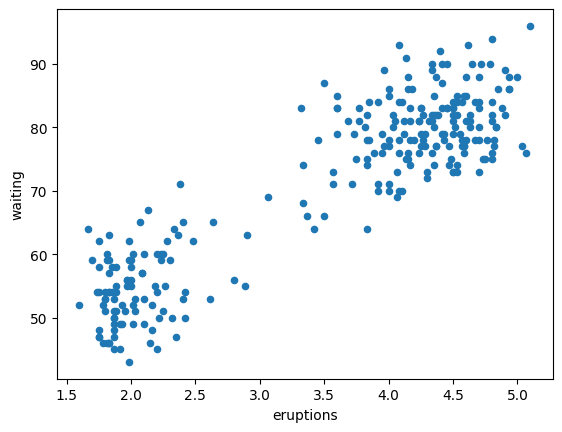

In [12]:
of_dat.plot.scatter('eruptions','waiting')

In [20]:
np.array(of_dat).shape

(272, 2)

In [181]:
def gibbs_gmm(y,K,mu0,steps,burnin_pct):
    
    # get sizes, calculate steps
    N,d=y.shape
    burnin_steps=int(steps*burnin_pct/(1-burnin_pct))
    total_steps=burnin_steps+steps+1
    print(total_steps)
    
    # init params
    xs=np.zeros((total_steps,N),dtype=int)
    xs[0,:]=np.random.randint(low=0,high=K,size=N)
    ws=np.ones((total_steps,K))/K
    mus=np.zeros((total_steps,K,d))
    mus[0,:,:]=mu0
    sigmas=np.ones((total_steps,K,d,d))
    for k in range(K): sigmas[0,k,:,:]=np.eye(d)
    
    for t in range(total_steps-1):
        print(str(t+1)+'/'+str(total_steps-1))
        
        # update indices ###
        # first obtain log probabilities
        tmplprbs=np.ones((N,K))*np.log(ws[t,:])
        for k in range(K): tmplprbs[:,k]+=stats.multivariate_normal(mus[t,k,:],sigmas[t,k,:,:]).logpdf(y)
        # then sample using gumbel-max trick
        G=np.random.gumbel(size=(N,K))
        tmpx=np.argmax(tmplprbs+G,axis=1)
        xs[t+1,:]=tmpx
        
        # get cluster summaries
        x_tuple=np.zeros((N,K),dtype=int)
        x_tuple[np.arange(N),tmpx]=1
        Nks=np.sum(x_tuple,axis=0)
        
        # update weights ###
        tmpw=np.random.dirichlet(Nks+1)
        ws[t+1,:]=tmpw
        
        # update means ###
        yks=np.sum(x_tuple[:,:,np.newaxis]*y[:,np.newaxis,:],axis=0)/Nks[:,np.newaxis] # cluster means
        for k in range(K): mus[t+1,k,:]=np.random.multivariate_normal(yks[k,:],sigmas[t,k,:,:]/Nks[k])
            
        # update covariances ###
        difs=y[:,np.newaxis,:]-mus[t+1,:,:].reshape(1,K,d)
        for k in range(K):
            tmpdif=difs[:,k,:]
            Sk=np.sum(tmpdif[:,:,np.newaxis]*tmpdif[:,np.newaxis,:]*x_tuple[:,k].reshape(N,1,1),axis=0)
            tmpsigma=stats.invwishart(N-d-1,Sk).rvs()
            sigmas[t+1,k,:,:]=tmpsigma
        # end for
    # end for
    return 0.

In [182]:
mu0=np.array([[2,50],[5,80]])
gibbs_gmm(y=np.array(of_dat),K=2,mu0=mu0,steps=1,burnin_pct=0.)

2
1/1


0.0

In [32]:
mu=np.array([2.,50.])
sigma=3*np.eye(2)
y=np.array(of_dat)
stats.multivariate_normal(mu,sigma).pdf(y).shape

(272,)